### Import the necessary program libraries

In [1]:
import pandas as pd
import plotly.graph_objects as go
from classes import KMeansClusterMain, BaseLoader
import plotly.express as px
from funcs import to_float, get_density, get_color
from matplotlib.colors import Normalize
from matplotlib import cm
import matplotlib.colors as mcolors
from sqlalchemy import create_engine
from settings import mariadb_string, mariadb_config

### Select the data

In [2]:
sql_query = """select 
	*
from
	stock_price s
where
	s.symbol = '{}'
group BY
	s.`date`
order by
	s.`date` asc;"""

loader = BaseLoader(mariadb_config)
symbol = loader.choose_id()
stock_name = loader.get_stock_name(symbol)
df_stock = pd.read_sql(sql_query.format(symbol), create_engine(mariadb_string))
df_stock["date"] = pd.to_datetime(df_stock["date"])
df_stock.info()

Please choose the symbol from the index which data should be analysed.
symbol ADS.DEX: Adidas
symbol AMZN: Amazon
symbol BKNG: Booking Holdings
symbol DASH: DoorDash
symbol FNTN.DE: Freenet
symbol HD: Home Depot
symbol LOW: Lowe’s
symbol MCD: McDonald's
symbol META: Meta Platforms Inc
symbol NKE: Nike
symbol NRDBY: Nordea Bank Abp ADR
symbol PAH3.DE: Porsche SE
symbol SBUX: Starbucks
symbol SDIV: Global X SuperDividend ETF
symbol SY1.DE: Symrise
symbol TJX: TJX Companies
symbol TSLA: Tesla
You can typ 'q' to quit.


symbol:  FNTN.DE


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5294 entries, 0 to 5293
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   symbol  5294 non-null   object        
 1   date    5294 non-null   datetime64[ns]
 2   open    5294 non-null   float64       
 3   high    5294 non-null   float64       
 4   low     5294 non-null   float64       
 5   close   5294 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 248.3+ KB


### Get the Volatility

In [3]:
# Volatility Calculation
df_stock['volatility_max'] = (df_stock['high'] - df_stock['low']).rolling(21).max()
df_stock['volatility_mean'] = (df_stock['high'] - df_stock['low']).rolling(21).mean()

In [4]:
df_stock.head()

,symbol,date,open,high,low,close,volatility_max,volatility_mean
0,FNTN.DE,2005-01-03,18.96,19.64,18.96,19.26,NaN,NaN
1,FNTN.DE,2005-01-04,19.31,19.83,18.76,18.83,NaN,NaN
2,FNTN.DE,2005-01-05,18.80,18.80,17.87,18.52,NaN,NaN
3,FNTN.DE,2005-01-06,18.50,18.57,17.80,17.93,NaN,NaN
4,FNTN.DE,2005-01-07,17.99,18.05,17.27,17.50,NaN,NaN


In [5]:
df_stock.tail()

,symbol,date,open,high,low,close,volatility_max,volatility_mean
5289,FNTN.DE,2025-10-24,27.48,27.48,27.00,27.40,0.7,0.402857
5290,FNTN.DE,2025-10-27,27.52,27.52,27.20,27.28,0.7,0.400000
5291,FNTN.DE,2025-10-28,27.40,27.40,26.90,27.34,0.7,0.410476
5292,FNTN.DE,2025-10-29,27.20,27.36,26.86,26.86,0.7,0.418095
5293,FNTN.DE,2025-10-30,26.96,27.04,26.84,26.84,0.7,0.407619


### Check the chart

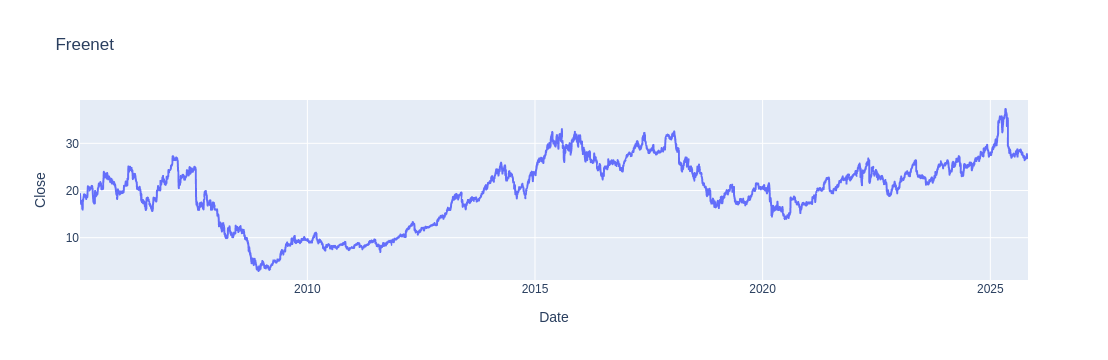

In [6]:
fig = px.line(df_stock, x="date", y="close", title=stock_name, 
              labels={"date": "Date", "close": "Close"})

fig.show()

### The Mean Volatility

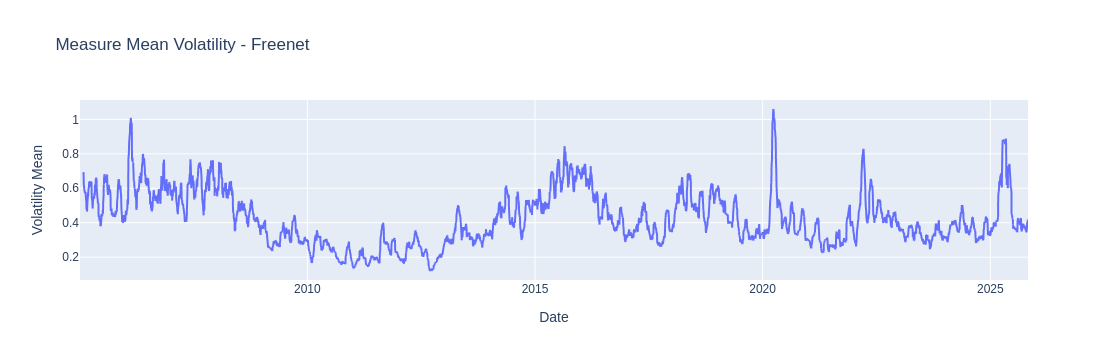

In [7]:
fig = px.line(df_stock, x="date", y="volatility_mean", title=f"Measure Mean Volatility - {stock_name}", 
              labels={"date": "Date", "volatility_mean": "Volatility Mean"})
fig.show()

### The Max Volatility

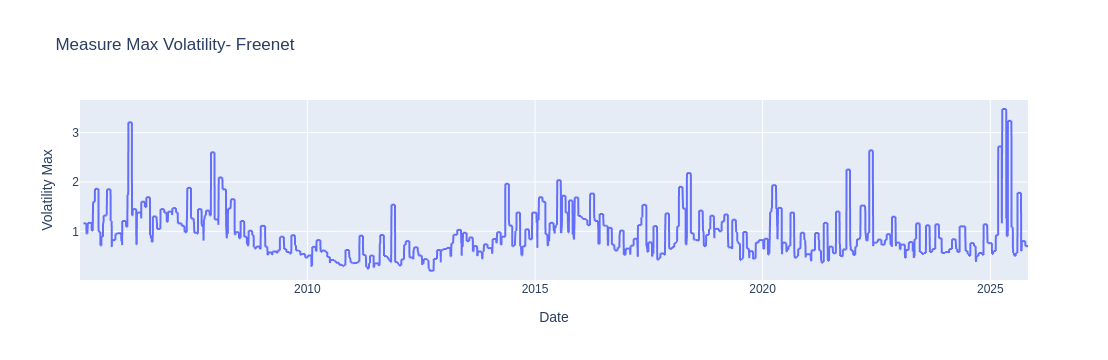

In [8]:
fig = px.line(df_stock, x="date", y="volatility_max", title=f"Measure Max Volatility- {stock_name}",
              labels={"date": "Date", "volatility_max": "Volatility Max"})
fig.show()

### Compute the main process

1. Calculate the percentage change on daily bases

2. Within the percentage change datapoints calculate the clusters with the help of the KMeans-Clustering-Algorithm

3. Calculate the necessary density column with the cluster labels and sum up the kmeans centroids with that and save them

In [9]:
# Compute the percentage change
df_stock["perc_change"] = df_stock["close"].pct_change()
df_stock.dropna(inplace=True)
df_stock = df_stock[df_stock['perc_change'] != 0.0]

# Here comes KMeans
datapoints = df_stock["perc_change"].to_list()
kmeans = KMeansClusterMain(3)
kmeans.fit(datapoints) 

# Assign the clusters
df_stock["cluster"] = kmeans.labels
df_stock["cluster"] = pd.to_numeric(df_stock["cluster"])

# Get the density for the colormap
df_stock["density"] = df_stock["cluster"].rolling(21).apply(get_density, kwargs={'orig_density': kmeans.centroids})

# cluster_str needed for kmeans volatility cluster graph.
df_stock["cluster_str"] = df_stock.cluster.astype(str)
df_stock['perc_change'] = df_stock['perc_change'] * 100

print(df_stock.isna().any())
print(df_stock.info())

symbol             False
date               False
open               False
high               False
low                False
close              False
volatility_max     False
volatility_mean    False
perc_change        False
cluster            False
density             True
cluster_str        False
dtype: bool
<class 'pandas.core.frame.DataFrame'>
Index: 5193 entries, 20 to 5293
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   symbol           5193 non-null   object        
 1   date             5193 non-null   datetime64[ns]
 2   open             5193 non-null   float64       
 3   high             5193 non-null   float64       
 4   low              5193 non-null   float64       
 5   close            5193 non-null   float64       
 6   volatility_max   5193 non-null   float64       
 7   volatility_mean  5193 non-null   float64       
 8   perc_change      5193 non-null   float64       
 9

### Determine the boundaries of the density

count    5173.000000
mean        0.006421
std         0.075244
min        -0.297064
25%        -0.042884
50%         0.019356
75%         0.053955
max         0.251981
Name: density, dtype: float64


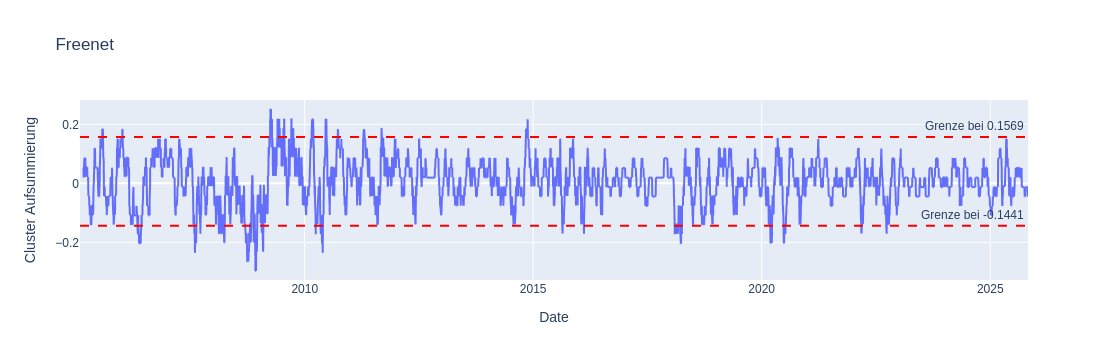

In [10]:
# Calculate the density
describe_ser = df_stock["density"].describe()
upper_limit = describe_ser["mean"] + (describe_ser["std"] * 2)
lower_limit = describe_ser["mean"] - (describe_ser["std"] * 2)
print(describe_ser)

# Show the density
fig = px.line(df_stock, x="date", y="density", title=stock_name,
                  labels={"date": "Date", "density": "Cluster Aufsummierung"})

fig.add_hline(y=upper_limit, line_dash="dash", line_color="red", annotation_text=f"Grenze bei {round(upper_limit,4)}")
fig.add_hline(y=lower_limit, line_dash="dash", line_color="red", annotation_text=f"Grenze bei {round(lower_limit,4)}")


fig.show()

### Checking the volatility in percentage daily changes

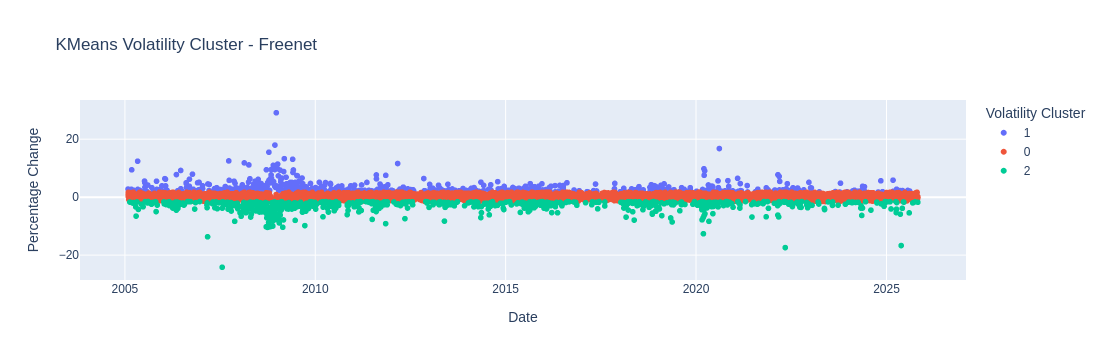

In [15]:
fig = px.scatter(df_stock, x="date", y="perc_change", color="cluster_str", 
                 title=f"KMeans Volatility Cluster - {stock_name}",
                 labels={"date": "Date", "perc_change": "Percentage Change", 
                         "cluster_str": "Volatility Cluster",})
fig.show()

In [18]:
# Need it for the trend direction
df_stock.loc[df_stock['cluster'] == 1]['perc_change'].describe()


count    592.000000
mean       3.375349
std        2.375845
min        1.736292
25%        2.095096
50%        2.536772
75%        3.737286
max       29.117647
Name: perc_change, dtype: float64

In [19]:
df_stock_truncated = df_stock.loc[df_stock["date"] > "2025-01-01"]

In [21]:
df_stock_truncated.loc[df_stock_truncated['cluster'] == 0]['perc_change'].describe()


count    180.000000
mean       0.176190
std        0.783209
min       -1.427552
25%       -0.380008
50%        0.136358
75%        0.765647
max        1.706485
Name: perc_change, dtype: float64

### Color the price history according to the column density

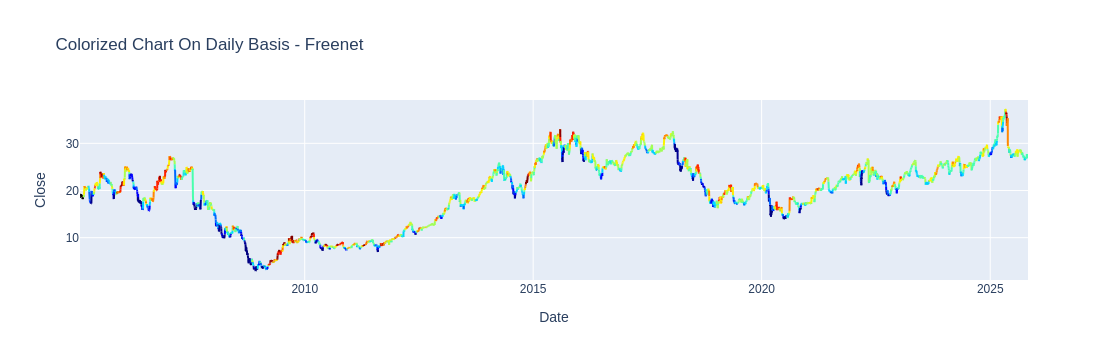

In [14]:
# Statistical limits for clipping
vmin = lower_limit
vmax = upper_limit

# Create normalization
norm = Normalize(vmin=vmin, vmax=vmax, clip=True)

# Create plotly-figure
fig = go.Figure()

# Draw line segments with colors based on density
for i in range(len(df_stock) - 1):
    density_value = df_stock["density"].iloc[i]
    color = get_color(density_value, norm)
    
    fig.add_trace(go.Scatter(
        x=df_stock["date"].iloc[i:i+2],  # Zwei Punkte verbinden
        y=df_stock["close"].iloc[i:i+2],
        mode="lines",
        line=dict(color=color, width=2),
        showlegend=False,
    ))

# Adjust layout
fig.update_layout(
    title=f"Colorized Chart On Daily Basis - {stock_name}",
    xaxis_title="Date",
    yaxis_title="Close",
    # Add colorbar
    coloraxis=dict(
        colorbar=dict(
            title="Density",
            ticktext=["Niedrig (Blau)", "Neutral (Grün)", "Hoch (Rot)"],
            tickvals=[vmin, (vmin+vmax)/2, vmax]
        ),
        colorscale="jet",
        cmin=vmin,
        cmax=vmax
    )
)

fig.show()


'NRDBY'